# Using BERT model

Loading Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

data = pd.read_csv("/content/drive/MyDrive/CS-688_Project/Amazon/train.csv", header=None)

In [3]:
data.head()

,0,1,2
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


In [4]:
data.shape

(3600000, 3)

In [5]:
izuo1 = data.loc[data[0] == 1]
izuo2 = data.loc[data[0] == 2]

In [6]:
train1 = izuo1[:100000]
train2 = izuo2[:100000]

In [7]:
train1 = train1.reset_index(drop=True)
train2 = train2.reset_index(drop=True)

In [8]:
#concading tran1 and train2
frames = [train1, train2]
data = pd.concat(frames)

In [9]:
data = data.reset_index(drop=True)

In [10]:
data = data.drop(columns=1)

In [11]:
data

,0,2
0,1,"This is a self-published book, and if you want..."
1,1,A complete waste of time. Typographical errors...
2,1,I guess you have to be a romance novel lover f...
3,1,I feel I have to write to keep others from was...
4,1,It's glaringly obvious that all of the glowing...
...,...,...
199995,2,Dr. Harvey Karp has come up with a way to help...
199996,2,We are expecting our first child and this book...
199997,2,We got this book upon a recommendation from an...
199998,2,I enjoyed this book and suggest reading it BEF...


## Loading Libraries

Doing some experimentations I notice that there was a CUDA error coming with older version of PyTorch, so it's advisable to upgrade PyTorch version.

In [ ]:
!pip install --upgrade torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 1.2 MB/s eta 0:00:48tcmalloc: large alloc 1147494400 bytes == 0x65812000 @  0x7f49c221f615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 890.2 MB 7.7 kB/s 
     |████████████████████████████████| 557.1 MB 10 kB/s 
     |████████████████████████████████| 317.1 MB 31 kB/s 
     |████████████████████████████████| 21.0 MB 95.8 MB/s 
     |████████████████████████████████| 849 kB 83.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
ERROR: pip's dependency resolv

In [12]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.3 MB/s 
     |████████████████████████████████| 7.6 MB 15.1 MB/s 
     |████████████████████████████████| 182 kB 82.9 MB/s 


In [13]:
import time
import random
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import tensorflow as tf
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, AdamW, BertConfig

In [14]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# If there's a GPU available...
if torch.cuda.is_available():    

    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")    

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Processing Data

In [15]:
data.rename(columns = {0:'sentiment', 2:'review'}, inplace = True)
data

,sentiment,review
0,1,"This is a self-published book, and if you want..."
1,1,A complete waste of time. Typographical errors...
2,1,I guess you have to be a romance novel lover f...
3,1,I feel I have to write to keep others from was...
4,1,It's glaringly obvious that all of the glowing...
...,...,...
199995,2,Dr. Harvey Karp has come up with a way to help...
199996,2,We are expecting our first child and this book...
199997,2,We got this book upon a recommendation from an...
199998,2,I enjoyed this book and suggest reading it BEF...


In [16]:
df=data

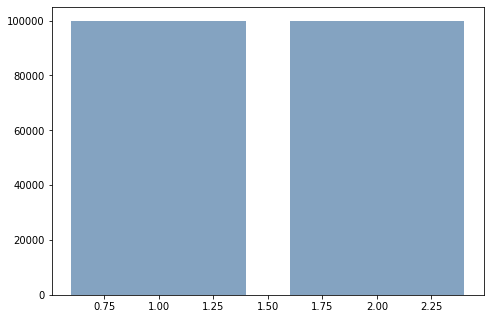

In [17]:
sentence = df['review'].tolist()
label1 = df['sentiment'].tolist()

c = Counter(label1)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Intent = []
Occurance = []
for i in c.items():
  Intent.append(i[0])
  Occurance.append(i[1])
ax.bar(Intent,Occurance,color=(0.2, 0.4, 0.6, 0.6))  
plt.show()


## Data Preparation

In [18]:
dic={1:0,2:1}
ans={0:1,1:2}

In [19]:
labels=data['sentiment']
sentence=data['review']
for i in tqdm(range(len(labels))):
  labels[i]=dic[labels[i]]

  0%|          | 0/200000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
100%|██████████| 200000/200000 [00:46<00:00, 4317.78it/s]


In [20]:
for i in tqdm(range(len(label1))):
 label1[i]=dic[label1[i]]

data={'sentence':sentence,'label1':labels}
df=pd.DataFrame(data)
print(len(df))
df=df.drop_duplicates()
print(len(df))

100%|██████████| 200000/200000 [00:00<00:00, 2245146.44it/s]


200000
199869


In [21]:
X_train, X_test, y_train, y_test = train_test_split(sentence, label1, test_size = 0.20, random_state = 0)

In [22]:
sentences = X_train
labels = y_train

In [23]:
label_1_num_classes = 2

label1 = torch.LongTensor(labels)

## Loading BERT Model and Creating Data Frame

In [24]:
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Print the original sentence.
print(' Original: ', sentences[0])
# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

 Original:  This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a "worst book" contest. I can't believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on "To Kill a Mockingbird"--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone as a joke---stay far, far away from this one!
Tokenized:  ['this', 'is', 'a', 'self', '-', 'published', 'book', ',', 'and', 'if', 'you', 'want', 'to', 'know', 'why', '-', '-', 'read', 'a', 'few', 'paragraph', '##s', '!', 'those', '5', 'star', 'reviews', 'must', 'have', 'been', 'written', 'by', 'ms', '.', 'ha

In [25]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in tqdm(sentences):
    encoded_dict = tokenizer.encode_plus(sent,add_special_tokens = True,max_length = 128,pad_to_max_length = True,
                        return_attention_mask = True, return_tensors = 'pt',)
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
all_labels = torch.stack([label1], dim=1)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

  0%|          | 0/160000 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 160000/160000 [05:18<00:00, 502.39it/s]


Original:  This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a "worst book" contest. I can't believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on "To Kill a Mockingbird"--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone as a joke---stay far, far away from this one!
Token IDs: tensor([  101,  1045,  2428,  5632,  2023,  2338,  1012,  2383,  2196,  3191,
         2023,  3166,  2077,  1010,  1045,  2134,  1005,  1056,  2113,  2054,
         2000,  5987,  1998,  1045,  2001, 27726,  4527,  1012,  1996,  2364,
         2839,  200

In [28]:
dataset = TensorDataset(input_ids, attention_masks, all_labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

144,000 training samples
16,000 validation samples


## Training on label 1

In [29]:
batch_size = 64
train_dataloader = DataLoader( train_dataset, shuffle=True, batch_size = batch_size)
validation_dataloader = DataLoader( val_dataset, shuffle=False, batch_size = batch_size )

# all_labels.size() -> torch.Size([4302, 2])

model = BertForSequenceClassification.from_pretrained( 
    "bert-base-uncased", num_labels = 2, output_attentions = False, output_hidden_states = False)

model.cuda()

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [30]:
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )

epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [31]:
def flat_accuracy(preds1,labels):
    pred_flat1 = np.argmax(preds1, axis=1).flatten()
    labels = labels.flatten() 
    labels_flat1=np.asarray(labels)
    acc1= np.sum(pred_flat1 == labels_flat1) / len(labels_flat1)
    #return (acc1+acc2)/2
    return acc1

In [32]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [34]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:

            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # print(b_labels.shape)

        model.zero_grad()        

        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       return_dict=True)
        label1_preds = result["logits"][:, :6]
        label1_loss = torch.nn.functional.cross_entropy(label1_preds, b_labels[:, 0])


        loss = label1_loss

        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_accuracy1 = 0
    total_eval_accuracy2 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           return_dict=True)

        label1_preds = result["logits"][:, :label_1_num_classes]
        label1_loss = torch.nn.functional.cross_entropy(label1_preds, b_labels[:, 0])


        loss = label1_loss 
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        label1_preds = label1_preds.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        eval_1 = flat_accuracy(label1_preds,label_ids)
        total_eval_accuracy1+=eval_1

    # Report the final accuracy for this validation run.
    avg_val_accuracy1 = total_eval_accuracy1 / len(validation_dataloader)
    print("  Accuracy1: {0:.2f}".format(avg_val_accuracy1))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur. Label1.': avg_val_accuracy1,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
    path = "epoch_"+str(epoch_i)+"_check.pth"
    torch.save(model.state_dict(), path)

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of  2,250.    Elapsed: 0:00:46.
  Batch    80  of  2,250.    Elapsed: 0:01:34.
  Batch   120  of  2,250.    Elapsed: 0:02:23.
  Batch   160  of  2,250.    Elapsed: 0:03:13.
  Batch   200  of  2,250.    Elapsed: 0:04:03.
  Batch   240  of  2,250.    Elapsed: 0:04:54.
  Batch   280  of  2,250.    Elapsed: 0:05:45.
  Batch   320  of  2,250.    Elapsed: 0:06:36.
  Batch   360  of  2,250.    Elapsed: 0:07:28.
  Batch   400  of  2,250.    Elapsed: 0:08:19.
  Batch   440  of  2,250.    Elapsed: 0:09:10.
  Batch   480  of  2,250.    Elapsed: 0:10:01.
  Batch   520  of  2,250.    Elapsed: 0:10:52.
  Batch   560  of  2,250.    Elapsed: 0:11:43.
  Batch   600  of  2,250.    Elapsed: 0:12:34.
  Batch   640  of  2,250.    Elapsed: 0:13:25.
  Batch   680  of  2,250.    Elapsed: 0:14:16.
  Batch   720  of  2,250.    Elapsed: 0:15:07.
  Batch   760  of  2,250.    Elapsed: 0:15:59.
  Batch   800  of  2,250.    Elapsed: 0:16:50.
  Batch   840  of

## Calculating testing accuracy.

In [35]:
data={'sentence':X_test,'label':y_test}
df=pd.DataFrame(data, columns =['label','sentence']) 

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

label_1_num_classes = 2

# from sklearn.preprocessing import LabelEncoder

# label1_encoder = LabelEncoder()

# label1 = [item[0] for item in labels]
# label1 = label1_encoder.fit_transform(label1)

label1 = torch.LongTensor(labels)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                sent,add_special_tokens = True,max_length = 128,pad_to_max_length = True, return_attention_mask = True,return_tensors = 'pt',)
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
all_labels = torch.stack([label1], dim=1)

# Set the batch size.  
batch_size = 32  


# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, all_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, shuffle=False, batch_size=batch_size)

Number of test sentences: 40,000



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [36]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))
prediction_list = []
real_list=[]
accuracy1 = 0
total_count = 0
misclassify1=0
misclassify_data=[]

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  #logits = result.logits
  label1_preds = result["logits"][:, :label_1_num_classes]

  # Move logits and labels to CPU
  label1_preds = label1_preds.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  label1_preds=np.argmax(label1_preds,axis=1)
  label_ids = label_ids.flatten()

  for i in range(len(label_ids)):
    prediction_list.append(label1_preds[i])
    real_list.append(label_ids[i])
    if(label1_preds[i]==label_ids[i]):
      accuracy1+=1
    else:
      misclassify1+=1

print("")

print("Number of Label1 correctly predicted: "+str(accuracy1))
print("Number of Label1 misclassify: "+str(misclassify1))

print("Label1 Testing Accuracy: {:.2f}".format(accuracy1/(accuracy1+misclassify1) ) )
bert_singlelabel_accuracy1 = accuracy1/(accuracy1+misclassify1)

Predicting labels for 40,000 test sentences...

Number of Label1 correctly predicted: 37707
Number of Label1 misclassify: 2293
Label1 Testing Accuracy: 0.94


In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

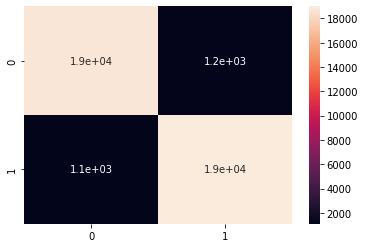

In [38]:
sns.heatmap(confusion_matrix(real_list,prediction_list), annot=True)
